# MRI Brain Tumor Segmentation

In this project, we will segment a brain tumor in MRI Images.

We will use `ResUNet Architecture` for the segmentation.

Also We will use `PyTorch`.

Dataset: [Brain MRI Segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation) 

We will follow this order:
1. Get data
2. Create datasets and dataloaders
3. Create Model
4. Train Model
5. Save Model
6. Evaluate and Visualize the model

## 1. Get Data

Download the data with following command from the command line.
```
!kaggle datasets download -d dmateuszbuda/lgg-mri-segmentation
```

**Note**: You may need to install and configure `kaggle` before downloading the data.

It will download the data with filename `lgg-mri-segmentation.zip`

We have to extract the data and set it up to create our datasets and dataloaders.

In [2]:
from pathlib import Path
from zipfile import ZipFile

data_path = Path('data')
mri_data_path = data_path/'mri_brain_tumor'

if mri_data_path.is_dir():
    print(f'{mri_data_path} already exists!')
else:
    mri_data_path.mkdir(parents=True, exist_ok=True)
    print(f'{mri_data_path} folders created')

zip_file_name = 'lgg-mri-segmentation.zip'

with ZipFile(zip_file_name, 'r') as zipfile:
    print('extracting...')
    zipfile.extractall(mri_data_path)
    print('extracted.')

data/mri_brain_tumor folders created
extracting...
extracted.


In [3]:
import pandas as pd
import numpy as np

import torch
import torchvision

In [5]:
# check datasets
brain_df = pd.read_csv('data/mri_brain_tumor/')
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

From the data we can see that we have total of `110` patients. 

That means there are images of `110` patients in the data.

In [24]:
import os
import random

all_imgs = list(mri_data_path.glob('*/*/*/*'))

# lets select random 5 images to see how the paths look like
random.seed(42) # seeding for reproducibility
random_samples = random.sample(all_imgs, k=5)

random_samples

[PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_7_mask.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_19_mask.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20.tif'),
 PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7855_19951020/TCGA_HT_7855_19951020_13.tif')]

We can see that some images are ending with `mask.tif` and some are not ending with that.

That means we have images and their respective mask in the data.

Let's visualize and see.

Lets take the `2nd data` from the random sample:

`PosixPath('data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_39.tif')`


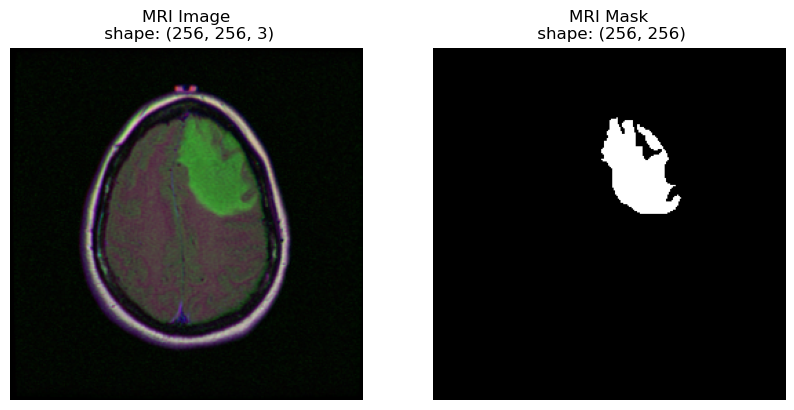

In [61]:
from PIL import Image
import matplotlib.pyplot as plt

# load the image
random_img = random_samples[1]
img = Image.open(random_img)

# get img folder
img_folder_path = random_img.parent

# getting just the name of the image
img_name = random_img.stem

# adding _mask in the image name to get the mask of the image
mask_name = f"{img_name.split('.tif')[0]}_mask.tif"

# adding together the img folder and the name of the mask to get the full path
# of the mask
mask_img_path = img_folder/mask_name

# loading the mask image
mask_img = Image.open(mask_img_path)

# turn the images(img and mask) into array before visualizing
img_asarray = np.asarray(img)
mask_img_asarray = np.asarray(mask_img)

# let's visualize the img and its mask

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(img_asarray)
plt.title(f'MRI Image\n shape: {img_asarray.shape}')
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(mask_img_asarray, cmap='gray') # we should do color map (cmap=gray) because by default matplotlib doesn't show grayscale images
plt.title(f'MRI Mask\n shape: {mask_img_asarray.shape}') # to see the shape of the image
plt.axis(False);


Beaufiful!

Now we have image and its mask, and we know how the path to those image and mask look like.
Image: 'data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/`TCGA_DU_6401_19831001_39.tif`'

Mask: 'data/mri_brain_tumor/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/`TCGA_DU_6401_19831001_39_mask.tif`'

## 2. Create dataset and Dataloaders